# Introduction

We will be looking at a dataset of homes sold between May 2014 and May 2015 in King's County in Washington (not DC). Among the cities included is Seattle, the state's largest city. The goal is to predict home prices in the data. This is a work in progress, there's a lot more I want to do before I can call myself happy with what I've done.

For reference, here are the features in the data:

-id: Id for a housing unit. May show up more than once in the data.

-date: date the house was sold

-price: price at which the house was sold

-bedroom: number of bedrooms

-bathrooms: number of bathrooms

-sqft_living: square footage of the living space

-sqft_lot: square footage of the lot

-floors: total floors in the house

-waterfront: house which has a view of the waterfront

-view: has been viewed

-condition: overall condition of the house

-grade: overall grade based on King County grading system

-sqft_above: square footage of the house, apart from basement

-sqft_basement: square footage of the basement

-yr_built: build year

-yr_renovated: year when house was renovated

-zipcode: ZIP

-lat: Latitude

-long: Longitude

-sqft_living15: Living room area in 2015(implies-- some renovations). This might or might not have affected the lotsize area.

-sqft_lot15: lotSize area in 2015(implies-- some renovations)


In [44]:
#Import dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression

## Obtain the data

In [2]:
house_df = pd.read_csv("kc_house_data.csv")

## Explore and Scrub the Data

In [3]:
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
id               21613 non-null int64
date             21613 non-null object
price            21613 non-null float64
bedrooms         21613 non-null int64
bathrooms        21613 non-null float64
sqft_living      21613 non-null int64
sqft_lot         21613 non-null int64
floors           21613 non-null float64
waterfront       21613 non-null int64
view             21613 non-null int64
condition        21613 non-null int64
grade            21613 non-null int64
sqft_above       21613 non-null int64
sqft_basement    21613 non-null int64
yr_built         21613 non-null int64
yr_renovated     21613 non-null int64
zipcode          21613 non-null int64
lat              21613 non-null float64
long             21613 non-null float64
sqft_living15    21613 non-null int64
sqft_lot15       21613 non-null int64
dtypes: float64(5), int64(15), object(1)
memory usage: 3.5+ MB


ID may not be too useful since it attains almost as many values as there are housing units. It might useful to know how many times a unit appears in this dataset and use that as a feature, but ID on its own isn't helpful. Date will probably be interesting; we could look for, say, seasonality trends. For now, though, let's not use it. I'm not entirely sure what view is doing... the Kaggle page just says "has been viewed," and I don't know what exactly that means. While zipcode is technically a number, for our purposes it would be better to treat it as a categorical variable.

Maybe we'll drop more columns later, but for now let's drop the ID column and the date column. We should also drop the sqft_above column since that depends linearly on the othe square foot measurements.

In [4]:
house_df = house_df.drop(['id'], axis=1)
house_df = house_df.drop(['date'], axis=1)
house_df = house_df.drop(['sqft_above'], axis=1)

Should we keep the zipcode? Lat and long contain the same information and more, but we need to be careful how we use them since they are numerical instead of categorical variables. If we were to fit with a GAM I think using lat and long would be the best idea. For a purely linear model... let's still use them and see how it goes.

In [5]:
house_df = house_df.drop(['zipcode'], axis=1)

We can make a correlation matrix to see if anything sticks out.

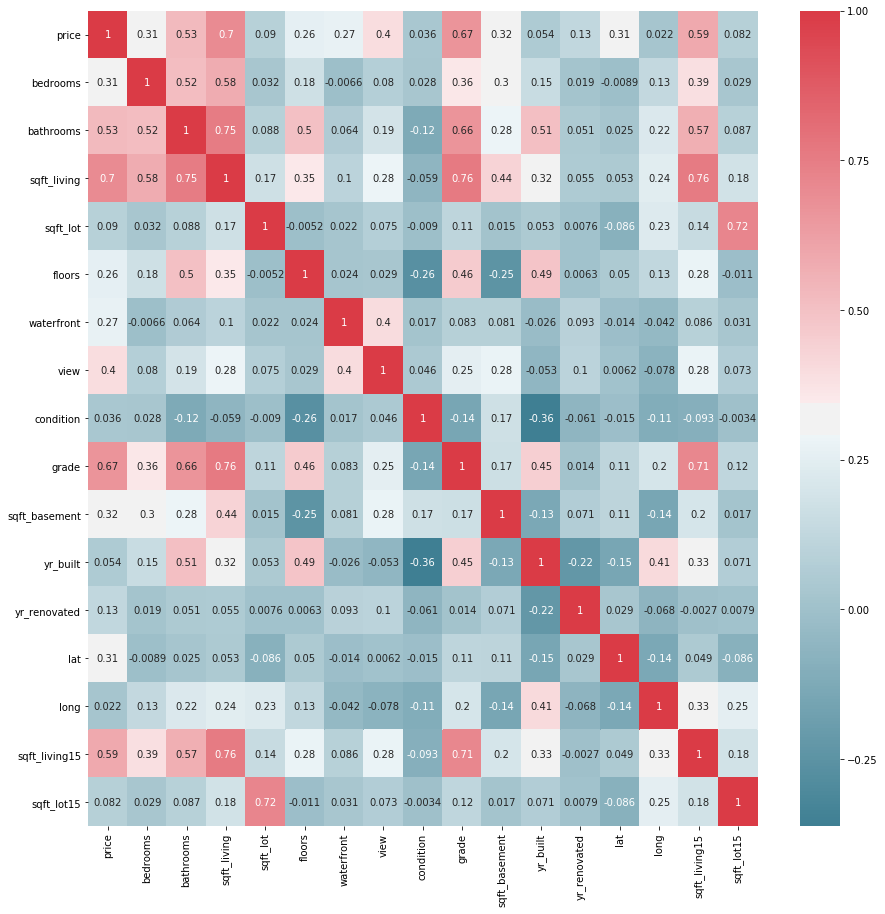

In [6]:
fig, ax = plt.subplots(figsize=(15,15))
sns.heatmap(house_df.corr(), annot=True, cmap=sns.diverging_palette(220, 10, as_cmap=True))

sqft_lot and sqft_lot15 are (unsurpringly) strongly correlated with one another, but are very weakly correlated with everything else. I suspect we'd be okay getting rid of them.

Something worth noting is that about 61% of the values for sqft_basement are zero. So, let's convert it to a binary has or does not have a basement.

In [24]:
len(house_df.loc[house_df['sqft_basement']==0])/len(house_df)

0.6073196687179012

In [26]:
house_df['sqft_basement'] = house_df['sqft_basement'].map(lambda x: 1 if x>0 else x)

## Modeling the Data
I'm kind of tired right now so I'm just going to throw everything into a linear regression model and see how it goes. I will take a log of the price first since it spans several decades in the data. The prices seem to follow a log-normal distribution, but I will go into that another time.

In [59]:
Y = np.log(house_df['price']+1).as_matrix()
X = house_df.drop(['price'], axis=1).as_matrix()

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, train_size = 0.7, random_state = 42)

lin_model = LinearRegression()
lin_model.fit(X_train, Y_train)

y_pred_train = lin_model.predict(X_train)
y_pred_test = lin_model.predict(X_test)

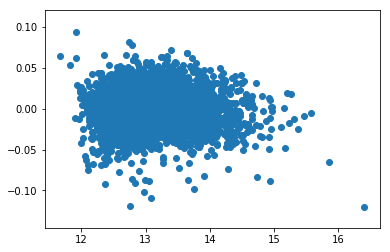

In [60]:
plt.scatter(y_pred_test, (Y_test - y_pred_test)/Y_test )

In [61]:
RMSE_train = np.sqrt(mean_squared_error(Y_train, y_pred_train))
RMSE_test = np.sqrt(mean_squared_error(Y_test, y_pred_test))
r2_train = r2_score(Y_train, y_pred_train)
r2_test = r2_score(Y_test, y_pred_test)

print("RMSE for train: ", RMSE_train)
print("RMSE for test: ", RMSE_test)
print("R2 value for train: ", r2_train)
print("R2 value for test: ", r2_test)

RMSE for train:  0.251680005486
RMSE for test:  0.256876640557
R2 value for train:  0.76984771756
R2 value for test:  0.766311487252


The errors and R^2 values are similar between the train and test data, indicating that it generalizes well. The R^2 is only about 77%, indicating a quarter of the variability in the data is left unaccounted for. I would like to get this up to 90%.